Load Frames

In [2]:
import os
from pathlib import Path
from PIL import Image
from IPython.display import display
from openai import OpenAI
from dotenv import load_dotenv
import base64

# Load API key from .env
load_dotenv()

client = OpenAI()

# Folder with extracted frames
FRAMES_DIR = Path("output_frames")  # <-- update if needed
image_paths = sorted(FRAMES_DIR.glob("*.jpg"))[:10]

print(f"Loaded {len(image_paths)} frames")


Loaded 10 frames


Display loaded frames

Displaying 10 frames...
Frame: frame_00000.jpg


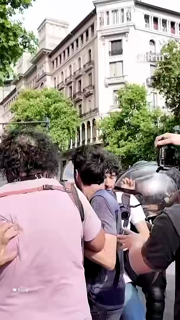

Frame: frame_00001.jpg


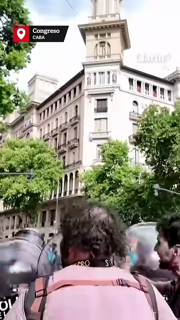

Frame: frame_00002.jpg


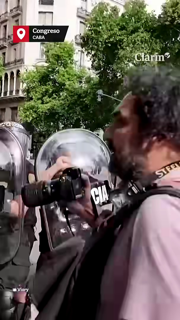

Frame: frame_00003.jpg


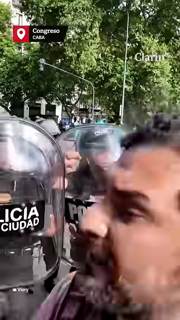

Frame: frame_00004.jpg


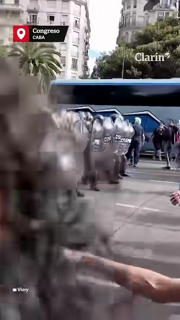

Frame: frame_00005.jpg


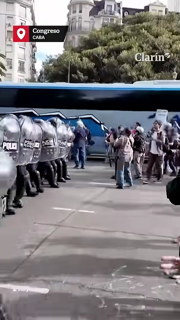

Frame: frame_00006.jpg


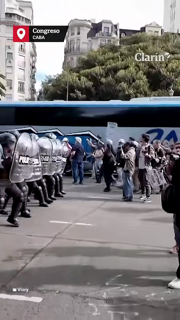

Frame: frame_00007.jpg


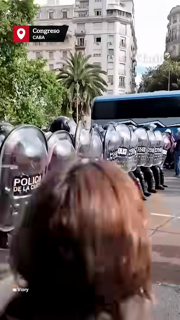

Frame: frame_00008.jpg


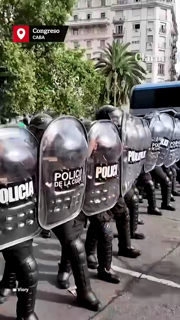

Frame: frame_00009.jpg


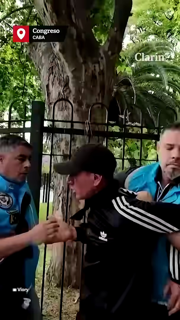

In [3]:
from IPython.display import display

print(f"Displaying {len(image_paths)} frames...")
for path in image_paths:
    img = Image.open(path)
    img.thumbnail((320, 320))
    print(f"Frame: {path.name}")
    display(img)


Generate image caption

Generating captions...

frame_00000.jpg:
Caption: The image shows a crowd of people, including photographers, gathered closely around an individual, set against a backdrop of buildings and greenery.


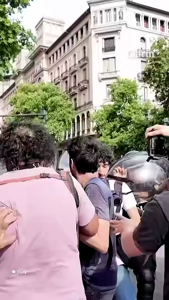


frame_00001.jpg:
Caption: The image shows a crowded scene near a building, likely during a protest or demonstration, with a focus on people holding cameras.


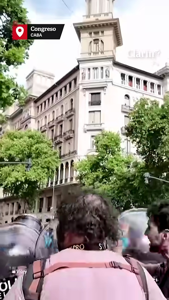


frame_00002.jpg:
Caption: The image shows a photographer facing off against police in riot gear at a protest in Congress, Buenos Aires.


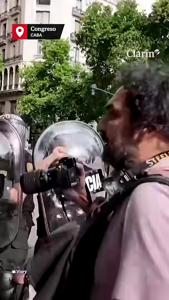


frame_00003.jpg:
Caption: The image shows a man in front of a police line with shields labeled "Policía Ciudad," amidst a rally or protest setting in Congreso, Buenos Aires.


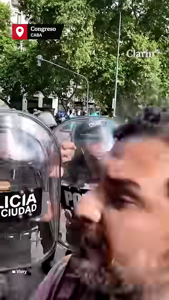


frame_00004.jpg:
Caption: The image shows a scene of tension with police in riot gear facing off against a crowd in an urban setting.


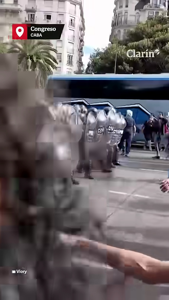


frame_00005.jpg:
Caption: The image shows a confrontation between police in riot gear and a group of demonstrators in an urban setting, likely during a protest.


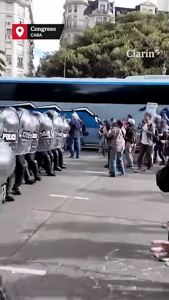


frame_00006.jpg:
Caption: The image shows a tense standoff between police in riot gear and a group of protesters in an urban setting.


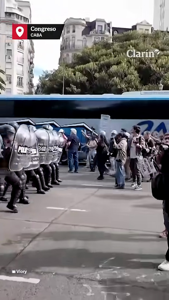


frame_00007.jpg:
Caption: The image shows a line of riot police in protective gear standing in formation, with a crowd visible in the foreground near the Congreso in Buenos Aires.


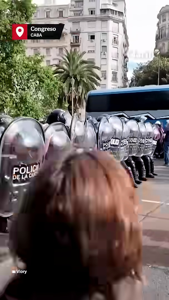


frame_00008.jpg:
Caption: The image shows a line of police officers in riot gear, holding shields, in an urban setting near the Congreso in Buenos Aires.


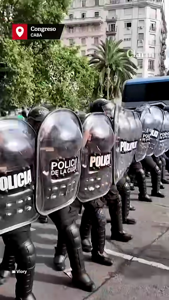


frame_00009.jpg:
Caption: The image depicts a confrontation between two individuals near a fence, with several people nearby seemingly intervening or controlling the situation.


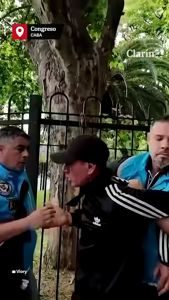

In [4]:
import base64
from IPython.display import display
from PIL import Image

def caption_image(image_path, model="gpt-4o-mini"):
    # Encode image
    with open(image_path, "rb") as f:
        img_b64 = base64.b64encode(f.read()).decode("utf-8")

    data_url = f"data:image/jpeg;base64,{img_b64}"

    # Ask the model for a caption
    response = client.responses.create(
        model=model,
        input=[{
            "role": "user",
            "content": [
                {"type": "input_image", "image_url": data_url},
                {"type": "input_text", "text": "Describe this image in one short, clear sentence."}
            ]
        }]
    )

    return response.output_text.strip()


# -------- RUN CAPTIONING FOR ALL FRAMES --------
captions = {}

print("Generating captions...")

for img_path in image_paths:
    caption = caption_image(img_path)
    captions[img_path] = caption

    print(f"\n{img_path.name}:")
    print("Caption:", caption)

    # ---- Display a thumbnail instead of full image ----
    try:
        img = Image.open(img_path)
        img.thumbnail((300, 300))  # create small thumbnail
        display(img)
    except Exception as e:
        print(f"Error displaying {img_path}: {e}")


Search frames with text-based queries

In [5]:
import math
import base64

def batch(iterable, batch_size=10):
    for i in range(0, len(iterable), batch_size):
        yield iterable[i:i+batch_size]


In [12]:
import time
def search_frames_batch(query: str, batch_size=10, model="gpt-4o-mini"):
    print(f"Searching for: {query}")
    results = []

    for frame_batch in batch(image_paths, batch_size):
        content_items = []

        # Add images using the required input_image format
        for image_path in frame_batch:
            with open(image_path, "rb") as f:
                img_b64 = base64.b64encode(f.read()).decode("utf-8")
            data_url = f"data:image/jpeg;base64,{img_b64}"

            content_items.append({
                "type": "input_image",
                "image_url": data_url
            })

        # -------- BASE SEARCH PROMPT WITH JUSTIFICATION --------
        content_items.append({
            "type": "input_text",
            "text": (
                f"You will see several images. Your task is to determine for EACH image "
                f"whether it clearly contains: '{query}'.\n\n"

                "Return a JSON list in the SAME order as the images, where each element is an object:\n"
                "{\n"
                "  \"match\": \"yes\" or \"no\",\n"
                "  \"reason\": \"one short, specific justification\"\n"
                "}\n\n"

                "Strict classification rules:\n"
                "- Answer 'yes' ONLY if the object is clearly visible and identifiable.\n"
                "- Answer 'no' if the object is missing, partially visible, uncertain, or only implied.\n"
                "- The justification MUST mention what is visible and why it supports the decision.\n"
                "- Do NOT describe the whole image—only justify the decision.\n"
                "- Do NOT output anything outside the JSON.\n"
                "- Do NOT use code fences.\n\n"

                "Example output:\n"
                "[\n"
                "  {\"match\": \"no\", \"reason\": \"only a person is visible\"},\n"
                "  {\"match\": \"yes\", \"reason\": \"a large building is clearly seen in the background\"}\n"
                "]"
            )
        })

        # -------- API CALL WITH RETRY --------
        while True:
            try:
                response = client.responses.create(
                    model=model,
                    input=[{
                        "role": "user",
                        "content": content_items
                    }]
                )

                raw_output = response.output_text.strip()   # <-- define it here
                break  # success → exit loop

            except RateLimitError:
                print("⏳ Rate limit reached, waiting 3 seconds...")
                time.sleep(3)



        # -------- CLEAN MODEL OUTPUT --------
        clean = raw_output.strip()

        # Remove code fences if present
        if clean.startswith("```"):
            clean = clean.split("```", 1)[1].strip()

        # Keep only JSON part
        if "[" in clean:
            clean = clean[clean.index("["):]

        # Parse JSON-like output
        try:
            parsed = eval(clean)
        except Exception:
            print("Could not parse:", clean)
            continue

        # -------- STORE RESULTS --------
        for img_path, item in zip(frame_batch, parsed):
            match_value = item.get("match", "").lower()
            reason_text = item.get("reason", "").strip()
            results.append((img_path, match_value, reason_text))

    return results


Run search

In [13]:
results = search_frames_batch("camera")
results


Searching for: camera


[(PosixPath('output_frames/frame_00000.jpg'),
  'no',
  'the camera is not clearly visible or identifiable'),
 (PosixPath('output_frames/frame_00001.jpg'),
  'no',
  'the camera is not clearly visible or identifiable'),
 (PosixPath('output_frames/frame_00002.jpg'),
  'yes',
  'a camera is held in front of a person clearly visible'),
 (PosixPath('output_frames/frame_00003.jpg'),
  'no',
  'the camera is not clearly visible or identifiable'),
 (PosixPath('output_frames/frame_00004.jpg'),
  'no',
  'the camera is not clearly visible or identifiable'),
 (PosixPath('output_frames/frame_00005.jpg'),
  'no',
  'the camera is not clearly visible or identifiable'),
 (PosixPath('output_frames/frame_00006.jpg'),
  'no',
  'the camera is not clearly visible or identifiable'),
 (PosixPath('output_frames/frame_00007.jpg'),
  'no',
  'the camera is not clearly visible or identifiable'),
 (PosixPath('output_frames/frame_00008.jpg'),
  'no',
  'the camera is not clearly visible or identifiable'),
 (Pos

Display matching frames

Displaying ONLY matching frames (match == yes):

frame_00002.jpg → YES
Reason: a camera is held in front of a person clearly visible


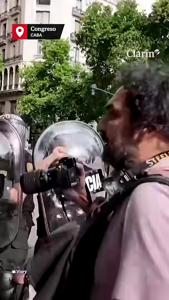


frame_00009.jpg → YES
Reason: a person is holding a camera clearly visible


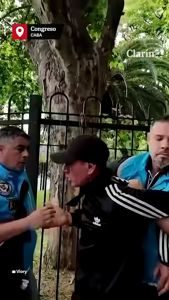

In [14]:
from PIL import Image
from IPython.display import display, HTML

print("Displaying ONLY matching frames (match == yes):")

for path, match, reason in results:
    if match.lower() != "yes":
        continue  # skip non-matching frames

    print(f"\n{path.name} → {match.upper()}")
    print("Reason:", reason)

    try:
        img = Image.open(path)
        img.thumbnail((300, 300))

        # Display image
        display(img)

    except Exception as e:
        print(f"Error loading {path}: {e}")
